# Exact integration of exponential function


I evaluate the following integral for general values of $a$ anb $b$, 
\begin{align}
I(a, b) &= \int_0^{1}\mathrm{d}x \int_{0}^{1-x}\mathrm{d}y
\left(
\exp(ax + by)
\right),\\
&= \frac{a (1-e^{b}) - b(1-e^{a})}{a b (a-b)}.
\end{align}


In [1]:
%matplotlib inline

from __future__ import print_function, division


# Import matplotlib.pyplot
import matplotlib.pyplot as plt

import scipy as sp
import numpy as np


import scipy.spatial as spatial
import scipy.linalg as la 


# Lookup machine epsilon 
EPS = sp.finfo(float).eps

In [2]:
TOL = 5e-3

def get_fab(a, b, tol=TOL, do_cases=True):
    """
    Evaluate the following expression:
      1/(b-a) * ((exp(b)-1) / b - (exp(a)-1) / a).
      
    """
    assert len(a.shape)==1
    assert len(b.shape)==1
    assert a.size==b.size

    # Initialize out
    out = sp.zeros_like(a)
    
    # Define the three possibly small quantities 
    bool_small_a = abs(a) <= tol
    bool_small_b = abs(b) <= tol
    bool_small_bma = abs(b-a) <= tol**2
    c = .5 * (a+b)
    d = .5 * (b-a)
    #bool_small_doverc = abs(d)**2 <= tol * abs(c)**2
    
    ## case 1 (small a)(big b, b-a)
    bool_case1 = sp.zeros_like(bool_small_a)
    if do_cases:
        bool_case1 = bool_small_a * (~bool_small_b) * (~bool_small_bma)
        _a = a[bool_case1]
        _b = b[bool_case1]
        out[bool_case1] = (
            sp.expm1(_b) / _b  
            - sp.exp(_a/2.0) * (
                1 + (_a**2)/24. + (_a**4)/(16.*120.))  
            ) / (_b - _a) 
    
    ## case 2 (small b)(big a, b-a)
    bool_case2 = sp.zeros_like(bool_small_b)
    if do_cases:
        bool_case2 = bool_small_b * (~bool_small_a) * (~bool_small_bma)
        _a = a[bool_case2]
        _b = b[bool_case2]
        out[bool_case2] = (
            sp.expm1(_a) / _a 
            - sp.exp(_b/2.0) * (
                1 + (_b**2)/24. + (_b**4)/(16.*120.))
            ) / (_a - _b) 
    
    
    ## Case 3: (vary small abs(a-b) < tol**2) (big a or b)
    bool_case3 = sp.zeros_like(bool_small_b)
    if do_cases:
        bool_case3 = (bool_small_bma * (~bool_small_a + ~bool_small_b))
        _a = a[bool_case3]
        _b = b[bool_case3]
        _c = .5 * (_a + _b)
        _d = .5 * (_b - _a)
        
        _d_even_powers = _d[:,None]**(2*sp.arange(3)[None, :])
        _c_even_powers = _c[:,None]**(2*sp.arange(3)[None, :])
        
        scale = _c**(-2) * (_d_even_powers/_c_even_powers).sum(-1) 
        term0 = 1 - sp.exp(_c) * (
            sp.dot(_d_even_powers, sp.array([1.0, 1.0/2.0, 1.0/24.])))
        term1 = _c * sp.exp(_c) * (
            sp.dot(_d_even_powers, sp.array([1.0, 1.0/6.0, 1.0/120.])))
        out[bool_case3] = scale * (term0 + term1) 
        
        
    ## case 4 (small b, a)
    bool_case4 = sp.zeros_like(bool_small_b)
    if do_cases:
        bool_case4 = bool_small_b * bool_small_a #* (~bool_small_bma)
        _a = a[bool_case4]
        _b = b[bool_case4]
        term0 = 1.0 / 2.0
        term1 = (_a + _b) / 6.0
        term2 = (_a**2 + _a * _b + _b**2) / (24.0)
        term3 = (_a**3 + _a**2 * _b + _a * _b**2 + _b**3) / (5 * 24.0)
        term4 = (_a**4 
                 + _a**3 * _b 
                 + _a**2 * _b**2 
                 + _a**1 * _b**3
                 + _b**4) / ((6 * 5) * 24.0)
        out[bool_case4] = term0 + term1 + term2 + term3 + term4

    
    ## All other cases can use the more simple rule given below
    _bool_else = ~(bool_case1 + bool_case2 + bool_case3 + bool_case4)
    _a = a[_bool_else]
    _b = b[_bool_else]
    B = -sp.expm1(_b) / _b
    A = -sp.expm1(_a) / _a
    out[_bool_else] = (B - A) / (_a - _b)
    
    
    return out
    


# CASES Testing

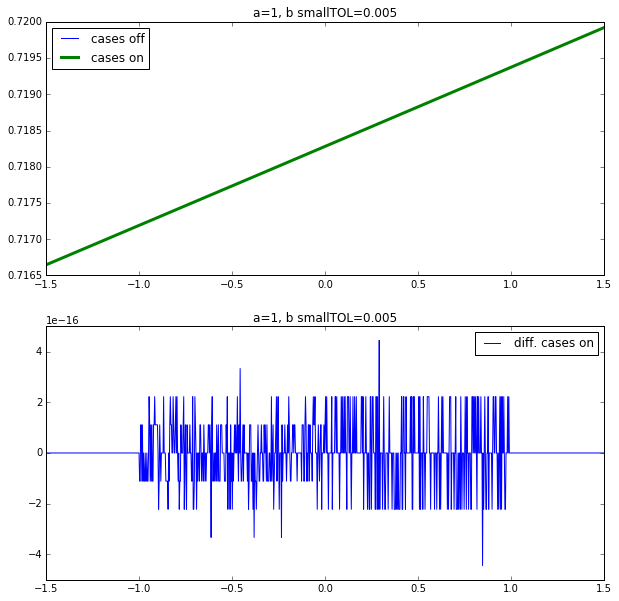

In [3]:
# Evaluate allong the line (b = -a + 2*TOL) 
ts = sp.linspace(-1.5, 1.5, 1000)
a = 1 + 0 * ts
b = TOL * ts
TITLE = "a=1, b small"


vals = get_fab(a, b)
vals_cases_off = get_fab(a, b, do_cases=False)

fig = plt.figure(1, (10, 10))

ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

ax0.plot(ts, vals_cases_off, color='blue', label="cases off")
ax0.plot(ts, vals, color='green', linewidth=3, label='cases on')
ax0.legend(loc='best')

ax1.plot(ts, vals-vals_cases_off, label='diff. cases on')
ax1.legend(loc='best')


ax0.set_title(TITLE+"TOL={}".format(TOL))
ax1.set_title(TITLE+"TOL={}".format(TOL))


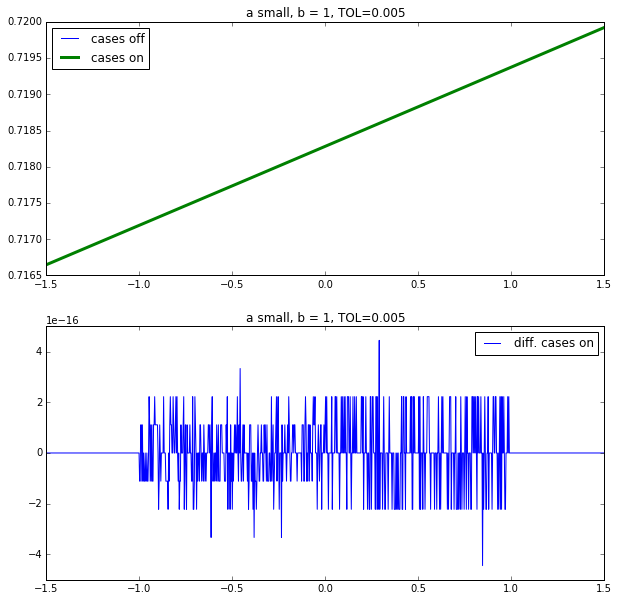

In [4]:
# Evaluate allong the line (b = -a + 2*TOL) 
ts = sp.linspace(-1.5, 1.5, 1000)
a = TOL * ts
b = 1 + 0 * ts
TITLE = "a small, b = 1, "


vals = get_fab(a, b)
vals_cases_off = get_fab(a, b, do_cases=False)

fig = plt.figure(1, (10, 10))

ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

ax0.plot(ts, vals_cases_off, color='blue', label="cases off")
ax0.plot(ts, vals, color='green', linewidth=3, label='cases on')
ax0.legend(loc='best')

ax1.plot(ts, vals-vals_cases_off, label='diff. cases on')
ax1.legend(loc='best')


ax0.set_title(TITLE+"TOL={}".format(TOL))
ax1.set_title(TITLE+"TOL={}".format(TOL))


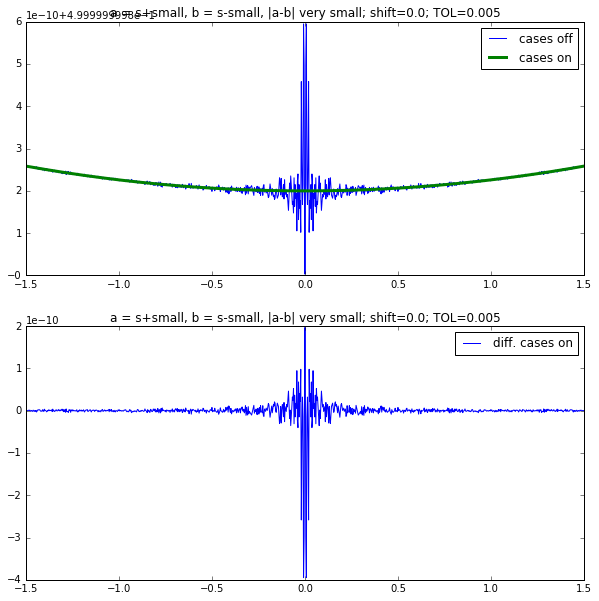

In [5]:
# Evaluate allong the line (b = -a + 2*TOL) 
ts = sp.linspace(-1.5, 1.5, 1000)
shift = 0.0
a = TOL**2 * ts + shift
b = -TOL**2 * ts + shift
TITLE = "a = s+small, b = s-small, |a-b| very small; shift={0:.3}; ".format(shift) 


vals = get_fab(a, b)
vals_cases_off = get_fab(a, b, do_cases=False)

fig = plt.figure(1, (10, 10))

ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

ax0.plot(ts, vals_cases_off, color='blue', label="cases off")
ax0.plot(ts, vals, color='green', linewidth=3, label='cases on')
ax0.legend(loc='best')

ax1.plot(ts, vals-vals_cases_off, label='diff. cases on')
ax1.legend(loc='best')


ax0.set_title(TITLE+"TOL={}".format(TOL))
ax1.set_title(TITLE+"TOL={}".format(TOL))


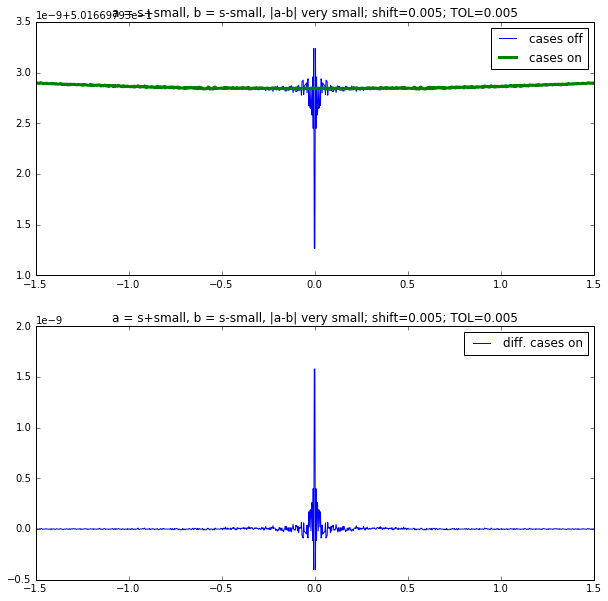

In [6]:
# Evaluate allong the line (b = -a + 2*TOL) 
ts = sp.linspace(-1.5, 1.5, 1000)
shift = TOL
a = TOL**2 * ts + shift
b = -TOL**2 * ts + shift
TITLE = "a = s+small, b = s-small, |a-b| very small; shift={0:.3}; ".format(shift) 


vals = get_fab(a, b)
vals_cases_off = get_fab(a, b, do_cases=False)

fig = plt.figure(1, (10, 10))

ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

ax0.plot(ts, vals_cases_off, color='blue', label="cases off")
ax0.plot(ts, vals, color='green', linewidth=3, label='cases on')
ax0.legend(loc='best')

ax1.plot(ts, vals-vals_cases_off, label='diff. cases on')
ax1.legend(loc='best')


ax0.set_title(TITLE+"TOL={}".format(TOL))
ax1.set_title(TITLE+"TOL={}".format(TOL))


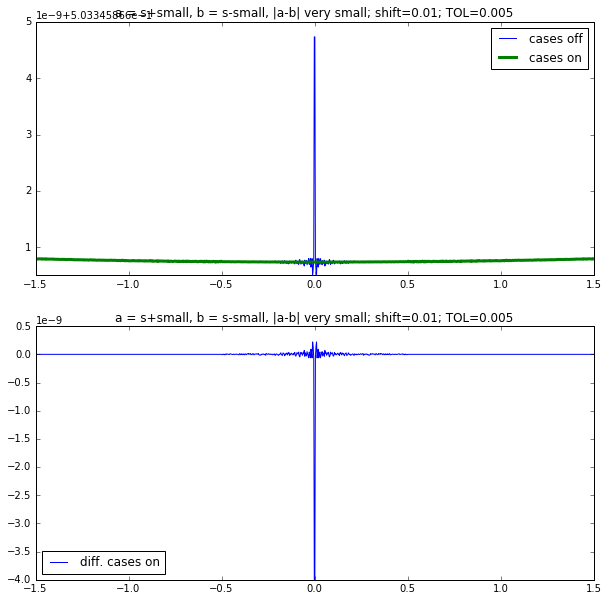

In [7]:
# Evaluate allong the line (b = -a + 2*TOL) 
ts = sp.linspace(-1.5, 1.5, 1000)
shift = 2*TOL
a = TOL**2 * ts + shift
b = -TOL**2 * ts + shift
TITLE = "a = s+small, b = s-small, |a-b| very small; shift={0:.3}; ".format(shift) 


vals = get_fab(a, b)
vals_cases_off = get_fab(a, b, do_cases=False)

fig = plt.figure(1, (10, 10))

ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

ax0.plot(ts, vals_cases_off, color='blue', label="cases off")
ax0.plot(ts, vals, color='green', linewidth=3, label='cases on')
ax0.legend(loc='best')

ax1.plot(ts, vals-vals_cases_off, label='diff. cases on')
ax1.legend(loc='best')


ax0.set_title(TITLE+"TOL={}".format(TOL))
ax1.set_title(TITLE+"TOL={}".format(TOL))


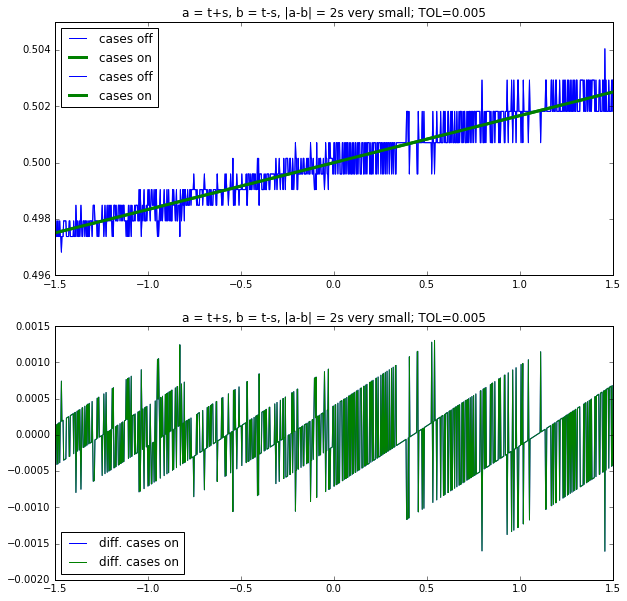

In [8]:
# Evaluate allong the line (b = -a + 2*TOL) 
ts = sp.linspace(-1.5, 1.5, 1000)
shift = 1e-13
a = TOL * ts + shift
b = TOL * ts - shift
TITLE = "a = t+s, b = t-s, |a-b| = 2s very small; "


vals = get_fab(a, b)
vals_cases_off = get_fab(a, b, do_cases=False)

fig = plt.figure(1, (10, 10))

ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

ax0.plot(ts, vals_cases_off, color='blue', label="cases off")
ax0.plot(ts, vals, color='green', linewidth=3, label='cases on')
ax0.legend(loc='best')

ax1.plot(ts, vals-vals_cases_off, label='diff. cases on')
ax1.legend(loc='best')


ax0.set_title(TITLE+"TOL={}".format(TOL))
ax1.set_title(TITLE+"TOL={}".format(TOL))
# Evaluate allong the line (b = -a + 2*TOL) 
ts = sp.linspace(-1.5, 1.5, 1000)
shift = 1e-13
a = TOL * ts + shift
b = TOL * ts - shift
TITLE = "a = t+s, b = t-s, |a-b| = 2s very small; "


vals = get_fab(a, b)
vals_cases_off = get_fab(a, b, do_cases=False)

fig = plt.figure(1, (10, 10))

ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

ax0.plot(ts, vals_cases_off, color='blue', label="cases off")
ax0.plot(ts, vals, color='green', linewidth=3, label='cases on')
ax0.legend(loc='best')

ax1.plot(ts, vals-vals_cases_off, label='diff. cases on')
ax1.legend(loc='best')


ax0.set_title(TITLE+"TOL={}".format(TOL))
ax1.set_title(TITLE+"TOL={}".format(TOL))

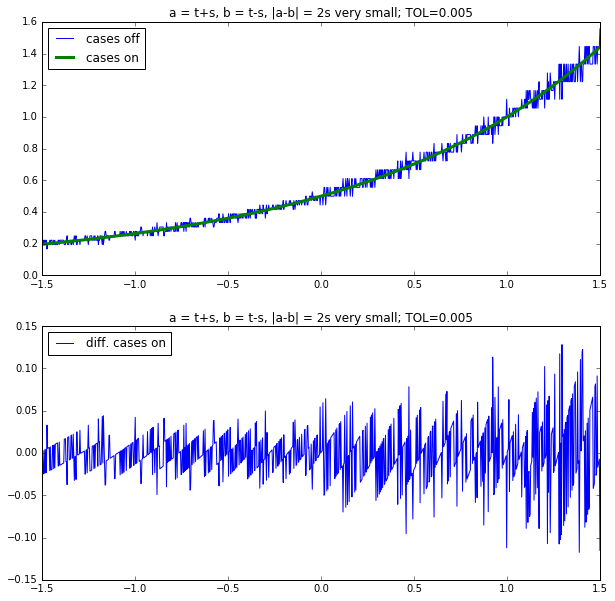

In [9]:
# Evaluate allong the line (b = -a + 2*TOL) 
ts = sp.linspace(-1.5, 1.5, 1000)
shift = 2e-15
a =  ts + shift
b =  ts - shift
TITLE = "a = t+s, b = t-s, |a-b| = 2s very small; "


vals = get_fab(a, b)
vals_cases_off = get_fab(a, b, do_cases=False)

fig = plt.figure(1, (10, 10))

ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

ax0.plot(ts, vals_cases_off, color='blue', label="cases off")
ax0.plot(ts, vals, color='green', linewidth=3, label='cases on')
ax0.legend(loc='best')

ax1.plot(ts, vals-vals_cases_off, label='diff. cases on')
ax1.legend(loc='best')


ax0.set_title(TITLE+"TOL={}".format(TOL))
ax1.set_title(TITLE+"TOL={}".format(TOL))

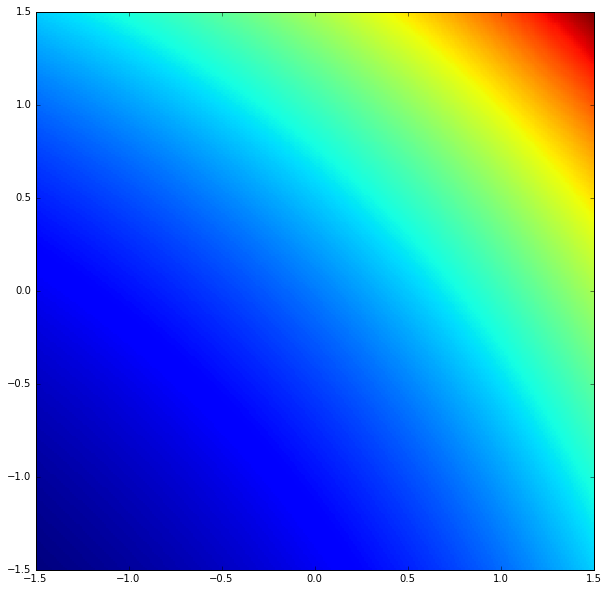

In [16]:
# Finally evaluate the function for (a, b) on a grid
_x = sp.linspace(-1.5, 1.5, 301)
aa, bb = sp.meshgrid(_x, _x, indexing='ij')
vals = get_fab(aa.ravel(), bb.ravel()).reshape(aa.shape)


## 
fig = plt.figure(2, (10, 10))
ax = fig.add_subplot(1,1,1)
ax.pcolor(aa, bb, vals)
